In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
from time import time

import pyro
import torch
import pyro.optim as optim
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, JitTrace_ELBO, Predictive, MCMC, NUTS
from pyro.distributions import constraints
from pyro.poutine import reparam
from pyro.infer.reparam import LocScaleReparam
from sklearn.preprocessing import StandardScaler

pyro.enable_validation(True)

# Questions for Gurpreet
- We can use observed dummy/categorical variables, correct?

# Story Level Model
Here, we will model each post as coming from one of four types.

# Data

First, we load the Reddit datasets

In [2]:
comments = dict()
with open('../data/results/Comments.json') as f:
    for line in f:
        post = json.loads(line)
        comments[post['pid']] = post['api_num_comments'], post['comments']

In [3]:
corrections = []
with open('../data/results/CorrectionPairs.json') as f:
    for line in f:
        corrections.append(json.loads(line))

In [4]:
news = []
with open('../data/results/NewsPairs.json') as f:
    for line in f:
        news.append(json.loads(line))

In [5]:
([n for n in news if len(n['r']['countries']) == 21])

[{'r': {'uid': 'b123ebd6-b1ce-264c-652b-e709ecb7d5e6',
   'claimDate': '2019-07-22T00:00:00.000Z',
   'reviewDate': '2019-07-22T00:00:00.000Z',
   'reviewUrl': 'https://www.polygraph.info/a/fact-check-russian-black-sea-presence-becoming-physically-disruptive/30065465.html',
   'claimReviewed': '“The Ukrainian Navy’s claims that the Black Sea Fleet’s Smetlivy patrol vessel entered the closed area of the Sea Breeze 2019 exercise are untrue.”',
   'countries': ['gr',
    'ru',
    'dk',
    'no',
    'tr',
    'fr',
    'ge',
    'lv',
    'it',
    'lt',
    'gb',
    'ee',
    'md',
    'pl',
    'us',
    'tw',
    'ua',
    'ca',
    'sy',
    'se',
    'bg'],
   'claimReviewed_en': None,
   'reviewAuthor': {'name': 'POLYGRAPH.info', 'authorURL': 'polygraph.info'},
   'reviewRating': {'ratingValue': 1,
    'worstRating': 1,
    'bestRating': 5,
    'alternateName': 'Likely False',
    'isFakeClaim': True,
    'isFakeStory': True},
   'claimAuthor': {'name': "Russia's Black Sea Fleet",

In [6]:
news[0]

{'r': {'uid': 'b123ebd6-b1ce-264c-652b-e709ecb65d2f',
  'claimDate': '2017-10-02T00:00:00.000Z',
  'reviewDate': '2017-10-05T17:40:10.000Z',
  'reviewUrl': 'http://www.politifact.com/truth-o-meter/statements/2017/oct/05/steve-israel/former-democratic-congressman-compares-gun-violenc/',
  'claimReviewed': 'Says the Dickey Amendment "prevents the Centers for Disease Control and Prevention from even researching the relationship between gun violence and public health. ... The government can’t study gun violence but is spending $400,000 analyzing the effects of Swedish massages on rabbits."',
  'countries': ['us'],
  'claimReviewed_en': None,
  'reviewAuthor': {'name': 'PolitiFact', 'authorURL': 'politifact.com'},
  'reviewRating': {'ratingValue': 5,
   'worstRating': 1,
   'bestRating': 7,
   'alternateName': 'Mostly True',
   'isFakeClaim': False,
   'isFakeStory': False},
  'claimAuthor': {'name': 'Steve Israel',
   'claimURL': 'https://www.nytimes.com/2017/10/02/opinion/gun-control-vega

In [7]:
len({n['p']['subreddit'] for n in (corrections + news)})

1333

Gather relevant variables

In [8]:
def processData(items, comments, minutes=60):
    
    # story level
    sids = list(sorted({n['r']['uid'] for n in items}))
    sid_indices = {sid: i for i, sid in enumerate(sids)}
    
    countries = list(sorted({c for n in items for c in n['r']['countries']}))
    country_indices = {country: i for i, country in enumerate(countries)}
    
    authors = list(sorted({n['r']['reviewAuthor']['authorURL'] for n in items}))
    author_indices = {author: i for i, author in enumerate(authors)}
    
    story_claim_titles = [""] * len(sids)
    
#     s_data = np.zeros((len(sids), 1 + len(countries) + len(authors)))
    s_data = np.zeros((len(sids), 1 + len(authors)))
    # bias.
    s_data[:,0] = 1
    
    # subreddit level
    subreddits = list(sorted({n['p']['subreddit'] for n in items}))
    subreddit_indices = {subreddit: i for i, subreddit in enumerate(subreddits)}
    
    r_data = np.concatenate([np.ones((len(subreddits),1)), np.eye(len(subreddits))], axis=1)
    
    # type level
    # This t_data is just encoding each with its own dummy (with bias terms)
    t_data = np.array([[1, 1, 0, 0, 0],
                       [1, 0, 1, 0, 0],
                       [1, 0, 0, 1, 0],
                       [1, 0, 0, 0, 1]])
    
    
    # post level
    p_stories = np.empty((len(items),))
    p_subreddits = np.empty((len(items),))
    p_types = np.empty((len(items),))
    y = np.empty((len(items),))
    
    num_p_indep = 7
    p_data = np.zeros((len(items), num_p_indep))
    
    # set bias
    p_data[:,0] = 1
    
    for i, n in enumerate(items):
        
        # post-level
        isNews = 'isFakeStory' in n['r']['reviewRating']
        news_id = n['p']['id']
        
        # story-level
        story_id = n['r']['uid']
        
        claim_title = n['r']['claimReviewed']
        p_countries = n['r']['countries']
        review_author = n['r']['reviewAuthor']['authorURL']
        
        p_stories[i] = sid_indices[story_id]
        
#         for c in p_countries:
#             s_data[sid_indices[story_id], 1 + country_indices[c]] = 1
            
        s_data[sid_indices[story_id], 1 + author_indices[review_author]] = 1
        
        story_claim_titles[sid_indices[story_id]] = claim_title
        
        # subreddit-level
        subreddit = n['p']['subreddit']
        p_subreddits[i] = subreddit_indices[subreddit]
        
        num_cmts, cmts = comments[news_id]
        c_body_lens = []
        c_ups = []
        c_downs = []
        unique_authors = set()
        for c in cmts:
            # skip if comment not created in first _ mins
            if c['delta_seconds'] > minutes * 60:
                continue

            c_minutes = c['delta_seconds'] / 60
            if c_minutes <= minutes:   # cmts in first _ mins
                p_data[i, 6] += 1
            
            c_body_lens.append(c['body_len'])
            c_ups.append(c['ups'])
            c_downs.append(c['downs'])
            
            if c['author']:
                unique_authors.add(c['author'])
        
        if isNews:
            p_types[i] = 1 if n['r']['reviewRating']['isFakeStory'] else 0
        else:
            p_types[i] = 3 if n['r']['reviewRating']['isFakeClaim'] else 2
            
        y[i] = num_cmts
        p_data[i, 1] = np.mean(c_body_lens) if c_body_lens else 0.
        p_data[i, 2] = np.std(c_body_lens) if c_body_lens else 0.
        p_data[i, 3] = np.mean(c_ups) if c_ups else 0.
        p_data[i, 4] = np.std(c_ups) if c_ups else 0.
        p_data[i, 5] = len(unique_authors) if unique_authors else 0.
    
    # Adjust p_data
    
    # normalize avg net upvotes by std net upvotes:
    # TODO should we do this +1?
    p_data[:,3] = p_data[:, 3] / (p_data[:, 4] + 1)
    
    # select relevant indep vars
    p_data = p_data[:, (0,1,3,5,6)]  # bias, avg cmt length, avg net upvotes, num authors, num initial comments
        
    
    data_tuple = (p_data, t_data, s_data, r_data, y)
    lookup_tuple = (p_types, p_stories, p_subreddits)
    label_tuple = (countries, authors, story_claim_titles, subreddits)
        
    return data_tuple, lookup_tuple, label_tuple

### Process and Unpack Data

In [62]:
data_tuple, lookup_tuple, label_tuple = processData(news + corrections, comments)

In [63]:
p_data, t_data, s_data, r_data, y = data_tuple
p_types, p_stories, p_subreddits = lookup_tuple
countries, authors, story_claim_titles, subreddits = label_tuple

p_data variables (in order):

0. bias
1. comment_length_avg
2. normalized comment_upvotes_avg
3. num_unique_comment_authors
4. num_comments in first _ mins

types

0. Real News
1. Fake News
2. Correction on Real News
3. Correction on Fake News

t_data variables (in order):

0. bias
1. Real News Dummy
2. Fake News Dummy
3. Correction on Real News Dummy
4. Correction on Fake News Dummy

s_data variables:

0. bias
1. country dummies (multiple may be "on")
2. author dummies

r_data variables:

0. bias
1. subreddit dummies

### Data Transformations

In [64]:
# before we change anything, save the original p_data
original_p_data = p_data.copy()

#### log some data.

In [65]:
# num initial comments
p_data[:,4] = np.log(p_data[:,4] + 1)

# avg upvotes
#p_data[:,2] = np.log(p_data[:,2] + 1)

# num authors
p_data[:,3] = np.log(p_data[:,3] + 1)

# avg comment len
p_data[:,1] = np.log(p_data[:,1] + 1)

In [66]:
# scale our data.
scaler = StandardScaler()
p_data[:,[1,2,3,4]] = scaler.fit_transform(p_data[:,[1,2,3,4]])
#p_data[:,[1]] = scaler.fit_transform(p_data[:,[1]])

split into train/test

In [67]:
train_frac = 0.7
num_obs = p_data.shape[0]
idx = np.random.binomial(1, train_frac, size=num_obs).astype(bool)

p_data_train = p_data[idx,:]
p_data_test = p_data[~idx,:]

p_types_train = p_types[idx]
p_types_test = p_types[~idx]

p_stories_train = p_stories[idx]
p_stories_test = p_stories[~idx]

p_subreddits_train = p_subreddits[idx]
p_subreddits_test = p_subreddits[~idx]

y_train = y[idx]
y_test = y[~idx]

-----

# Modeling

Cast data to torch tensors

In [69]:
# data
p_data_train = torch.Tensor(p_data_train).double()
p_data_test = torch.Tensor(p_data_test).double()
t_data = torch.Tensor(t_data).double()
s_data = torch.Tensor(s_data).double()
r_data = torch.Tensor(r_data).double()

y_train = torch.Tensor(y_train).double()
y_test = torch.Tensor(y_test).double()

# types
p_types_train = torch.Tensor(p_types_train).long()
p_types_test = torch.Tensor(p_types_test).long()
p_stories_train = torch.Tensor(p_stories_train).long()
p_stories_test = torch.Tensor(p_stories_test).long()
p_subreddits_train = torch.Tensor(p_subreddits_train).long()
p_subreddits_test = torch.Tensor(p_subreddits_test).long()

2 Regressions.

Post-Level Regression

y_pt = phi_0,t * bias + phi_1,t * first_hour_comments + epsilon_pt

Type-Level Regressions (2)

phi_0t = eta_00 * bias + eta_01 silliness_t + nu_0t

phi_1t = eta_10 * bias + eta_11 silliness_t + nu_1t

In [16]:
def model(p_data, t_data, r_data, y, p_types, p_subreddits):
    coef_scale_prior = 0.1
        
    num_posts, num_p_indeps = p_data.shape
    num_types, num_t_indeps = t_data.shape
    num_subreddits, num_r_indeps = r_data.shape
    
    # type priors
    alpha_loc = torch.zeros((num_p_indeps, num_t_indeps), dtype=torch.float64)
    alpha_scale = coef_scale_prior * torch.ones((num_p_indeps, num_t_indeps), dtype=torch.float64)
    
    # type priors
    tau_loc = torch.zeros((num_p_indeps, num_r_indeps), dtype=torch.float64)
    tau_scale = coef_scale_prior * torch.ones((num_p_indeps, num_r_indeps), dtype=torch.float64)
    
    
    
    with pyro.plate("p_indep", num_p_indeps, dim=-2) as pi:
        
        # Type Level
        with pyro.plate("t_indep", num_t_indeps, dim=-1) as ti:
            eta = pyro.sample("eta", dist.Normal(alpha_loc, alpha_scale))
    
        with pyro.plate("type", num_types, dim=-1) as t:
            phi_loc = torch.matmul(eta, t_data[t,:].T) # (num_p_indeps, num_t_indeps) x (num_t_indeps, num_types)

            phi_dist = dist.Normal(phi_loc, coef_scale_prior)
            phi = pyro.sample("phi", phi_dist)
            
        # Subreddit Level

        with pyro.plate("r_indep", num_r_indeps, dim=-1) as ri:
            tau = pyro.sample("tau", dist.Normal(tau_loc, tau_scale))
    
        with pyro.plate("subreddit", num_subreddits, dim=-1) as r:
            rho_loc = torch.matmul(tau, r_data[r,:].T) # (num_p_indeps, num_r_indeps) x (num_r_indeps, num_subreddits)

            rho_dist = dist.Normal(rho_loc, coef_scale_prior)
            rho = pyro.sample("rho", rho_dist)
            
    # Gate
    
    with pyro.plate("subreddit2", num_subreddits, dim=-1):
        gate = pyro.sample("gate", dist.Beta(torch.ones((num_subreddits,), dtype=torch.float64),
                                               torch.ones((num_subreddits,), dtype=torch.float64),
                                              ))
    
#     gate = pyro.sample("gate", dist.Beta(2.*torch.ones((1,), dtype=torch.float64),
#                                          2.*torch.ones((1,), dtype=torch.float64),
#                                         ))
    
    
    # for each post, use the correct set of coefficients to run our post-level regression
    with pyro.plate("post", num_posts, dim=-1) as p:    
        t = p_types[p]
        r = p_subreddits[p]

        # indep vars for this post
        indeps = p_data[p,:]
        
        t_coefs = phi[:,t] # (num_p_indeps,num_posts)
        r_coefs = rho[:,r] # (num_p_indeps,num_posts)
        
        type_level_products = torch.mul(t_coefs, indeps.T) # (num_p_indeps, num_posts) .* (num_p_indeps, num_posts)
        subreddit_level_products = torch.mul(r_coefs, indeps.T) # (num_p_indeps, num_posts) .* (num_p_indeps, num_posts)

        # calculate the mean: desired shape (num_posts, 1)
        mu = (subreddit_level_products + type_level_products).sum(dim=0)  # (num_p_indeps, num_posts).sum(over indeps)
        
        # sample
        if y is None:
            pyro.sample("obs", dist.ZeroInflatedPoisson(rate=torch.exp(mu), gate=gate.flatten()[r]), obs=y)
        else:
            pyro.sample("obs", dist.ZeroInflatedPoisson(rate=torch.exp(mu), gate=gate.flatten()[r]), obs=y[p])


In [17]:
def guide(p_data, t_data, r_data, y, p_types, p_subreddits):
    coef_scale_prior = 0.1
    
    num_posts, num_p_indeps = p_data.shape
    num_types, num_t_indeps = t_data.shape
    num_subreddits, num_r_indeps = r_data.shape
    
    # define a prior for our regression variables
    
    # type level
    # The zeros and ones are the "alpha" in the graphical model from the proposal
    eta_loc = pyro.param("eta_loc", 
                         torch.zeros((num_p_indeps, num_t_indeps), dtype=torch.float64))
    eta_scale = pyro.param("eta_scale", 
                           coef_scale_prior * torch.ones((num_p_indeps, num_t_indeps), dtype=torch.float64), 
                           constraint=constraints.positive)
    
    phi_scale = pyro.param("phi_scale", 
                           coef_scale_prior * torch.ones((num_p_indeps, 1), dtype=torch.float64), 
                           constraint=constraints.positive) # share among all types.
    
    # subreddit level
    tau_loc = pyro.param("tau_loc", 
                          torch.zeros((num_p_indeps, num_r_indeps), dtype=torch.float64))
    tau_scale = pyro.param("tau_scale", 
                            coef_scale_prior * torch.ones((num_p_indeps, num_r_indeps), dtype=torch.float64), 
                            constraint=constraints.positive)
            
    rho_scale = pyro.param("rho_scale", 
                           coef_scale_prior * torch.ones((num_p_indeps, 1), dtype=torch.float64), 
                           constraint=constraints.positive) # share among all subreddits.
            
    with pyro.plate("p_indep", num_p_indeps, dim=-2) as pi:
        
        # type level
        
        with pyro.plate("t_indep", num_t_indeps, dim=-1) as ti:
            eta = pyro.sample("eta", dist.Normal(eta_loc, eta_scale))
    
        with pyro.plate("type", num_types, dim=-1) as t:
            phi_loc = torch.matmul(eta, t_data[t,:].T) # (num_p_indeps, num_t_indeps) x (num_t_indeps, num_types)

            phi = pyro.sample("phi", dist.Normal(phi_loc, phi_scale))
    
        # subreddit level

        with pyro.plate("r_indep", num_r_indeps, dim=-1) as ri:
            tau = pyro.sample("tau", dist.Normal(tau_loc, tau_scale))
    
        with pyro.plate("subreddit", num_subreddits, dim=-1) as r:
            rho_loc = torch.matmul(tau, r_data[r,:].T) # (num_p_indeps, num_r_indeps) x (num_r_indeps, num_subreddits)

            rho = pyro.sample("rho", dist.Normal(rho_loc, rho_scale))
    
    # Gate 
    
    gate_alpha = pyro.param("gate_alpha", 2.*torch.ones((num_subreddits,), dtype=torch.float64), constraint=constraints.positive)
    gate_beta = pyro.param("gate_beta", 2.*torch.ones((num_subreddits,), dtype=torch.float64), constraint=constraints.positive)
    with pyro.plate("subreddit2", num_subreddits, dim=-1):
        gate = pyro.sample("gate", dist.Beta(gate_alpha,gate_beta))
    
    
    return eta, phi, tau, rho


In [18]:
pyro.clear_param_store()

## Reparameterizations

In [19]:
# reparam_model = reparam(model, config={'phi': LocScaleReparam(0.), 
#                                        'rho': LocScaleReparam(0.)})

In [20]:
# reparam_guide = reparam(guide, config={'phi': LocScaleReparam(0.), 
#                                        'rho': LocScaleReparam(0.)})

# Inference

## SVI

In [21]:
SUBSAMPLE = False

svi = SVI(model,
          guide,
          optim.ClippedAdam({"lr": 1e-2}),
          loss=JitTrace_ELBO())

pyro.clear_param_store()

In [70]:
num_iters = 5000
losses = np.zeros((num_iters,))

start_time = time()

for i in range(num_iters):
    if SUBSAMPLE:
        elbo = svi.step(p_data_train[:250], t_data, r_data, y_train[:250], p_types_train[:250], p_subreddits_train[:250])
    else:
        elbo = svi.step(p_data_train, t_data, r_data, y_train, p_types_train, p_subreddits_train)
    losses[i] = elbo
    if i % 100 == 99:
        elapsed = time() - start_time
        remaining = (elapsed / (i+1)) * (num_iters - i)
        print(f"Iter {i+1}/{num_iters}"
              "\t||\t"
              f"Elbo loss: {elbo:.2e}"
              "\t||\t"
              f"Time Elapsed: {int(elapsed) // 60:02}:{int(elapsed) % 60:02}"
              "\t||\t"
              f"Est Remaining: {int(remaining) // 60:02}:{int(remaining) % 60:02}", end="\r", flush=True)

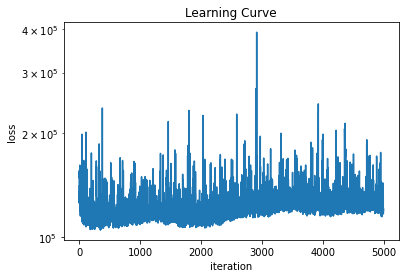

In [71]:
plt.plot(range(len(losses[:])), np.array(losses[:]))
plt.xlabel('iteration')
plt.ylabel('loss')
plt.yscale("log")
plt.title("Learning Curve")
plt.show()

----

In [72]:
import pyro.poutine as poutine

In [73]:
trace = poutine.trace(model).get_trace(p_data_train, t_data, r_data, y_train, p_types_train, p_subreddits_train)
trace.compute_log_prob()  # optional, but allows printing of log_prob shapes
print(trace.format_shapes())

  Trace Shapes:          
   Param Sites:          
  Sample Sites:          
   p_indep dist         |
          value       5 |
       log_prob         |
   t_indep dist         |
          value       5 |
       log_prob         |
       eta dist 5     5 |
          value 5     5 |
       log_prob 5     5 |
      type dist         |
          value       4 |
       log_prob         |
       phi dist 5     4 |
          value 5     4 |
       log_prob 5     4 |
   r_indep dist         |
          value    1334 |
       log_prob         |
       tau dist 5  1334 |
          value 5  1334 |
       log_prob 5  1334 |
 subreddit dist         |
          value    1333 |
       log_prob         |
       rho dist 5  1333 |
          value 5  1333 |
       log_prob 5  1333 |
subreddit2 dist         |
          value    1333 |
       log_prob         |
      gate dist    1333 |
          value    1333 |
       log_prob    1333 |
      post dist         |
          value   15297 |
       log_p

In [74]:
trace = poutine.trace(guide).get_trace(p_data_train, t_data, r_data, y_train, p_types_train, p_subreddits_train)
trace.compute_log_prob()  # optional, but allows printing of log_prob shapes
print(trace.format_shapes())

  Trace Shapes:            
   Param Sites:            
        eta_loc      5    5
      eta_scale      5    5
      phi_scale      5    1
        tau_loc      5 1334
      tau_scale      5 1334
      rho_scale      5    1
     gate_alpha        1333
      gate_beta        1333
  Sample Sites:            
   p_indep dist           |
          value      5    |
       log_prob           |
   t_indep dist           |
          value      5    |
       log_prob           |
       eta dist 5    5    |
          value 5    5    |
       log_prob 5    5    |
      type dist           |
          value      4    |
       log_prob           |
       phi dist 5    4    |
          value 5    4    |
       log_prob 5    4    |
   r_indep dist           |
          value   1334    |
       log_prob           |
       tau dist 5 1334    |
          value 5 1334    |
       log_prob 5 1334    |
 subreddit dist           |
          value   1333    |
       log_prob           |
       rho dist 5 13

## MCMC (NUTS)

In [75]:
#kernel = NUTS(model_no_subsample)

#num_iters = 1000
#warmup_steps = 500
#mcmc = MCMC(kernel, num_samples=num_iters, warmup_steps=warmup_steps)
#mcmc.run(p_data_train[:100], p_types_train[:100], t_data, y_train[:100])

In [76]:
#posterior_samples = mcmc.get_samples()

In [77]:
#eta_means = posterior_samples["eta"].mean(dim=0)
#eta_means

In [78]:
#phi_means = posterior_samples["phi"].mean(dim=0)
#phi_means

# Evaluation

Recall:

Variables (in order):

0. num_comments
1. type
2. comment_length_avg
3. comment_length_std
4. comment_upvotes_avg
5. comment_upvotes_std
6. num_unique_comment_authors
7. num_comments in first _ mins

types

0. Real News
1. Fake News
2. Correction on Real News
3. Correction on Fake News

t level Variables (in order):

0. Is Review? (vs. news)
1. Is about fake story? (Not included yet)

Check the fit

2 Regressions.

Post-Level Regression

y_pt = phi_0,t * bias + phi_1,t * first_hour_comments + epsilon_pt

Type-Level Regressions (2)

phi_0t = eta_00 * bias + nu_0t

phi_1t = eta_10 * bias + nu_1t

In [79]:
labels = np.array(["Factual News", "Fake News", "Review of Factual News", "Review of Fake News"])

<ipython-input-80-47e3fd595925>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_coefs = torch.tensor(phi[:,t]) # (num_p_indeps,num_posts)
<ipython-input-80-47e3fd595925>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_coefs = torch.tensor(rho[:,r]) # (num_p_indeps,num_posts)


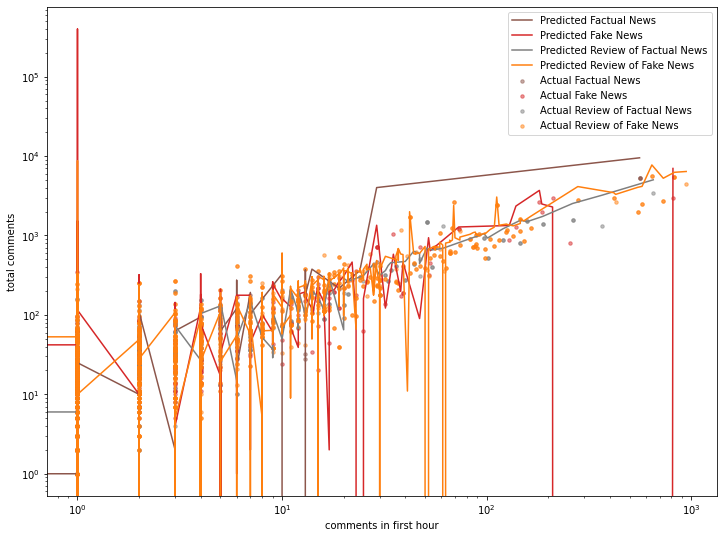

In [80]:
indep = 4

indep_dict = {
    1: "avg cmt length",
    2: "avg upvotes",
    3: "num authors",
    4: "comments in first hour",
}
# indep_dict = {
#     1: "comments in first hour",
# }

use_MCMC = False

if use_MCMC:
    eta_loc = eta_means
    tau_loc = tau_means
else:
    eta_loc = pyro.param('eta_loc').detach()
    tau_loc = pyro.param('tau_loc').detach()

phi = torch.matmul(eta_loc, t_data.T)
rho = torch.matmul(tau_loc, r_data.T)

t = torch.Tensor(p_types).long()
r = torch.Tensor(p_subreddits).long()

indeps = torch.tensor(p_data)

t_coefs = torch.tensor(phi[:,t]) # (num_p_indeps,num_posts)
r_coefs = torch.tensor(rho[:,r]) # (num_p_indeps,num_posts)

mu = (torch.mul(t_coefs, indeps.T) + torch.mul(r_coefs, indeps.T)).sum(dim=0)

y_pred = np.round(np.exp(mu))




# y_pred_mcmc = float(phi_means[0])
# y_pred_mcmc += float(phi_means[1]) * p_data[:,indep]


plt.figure(figsize=(12,9))

types = np.unique(p_types)

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
color_choices = np.random.choice(colors, size=len(types), replace=False)



for i, t in enumerate(types):
#     if t == 0:
        y_pred_t = y_pred[p_types == t]
        y_t = 1 * y[p_types == t]
        x_t = original_p_data[p_types == t,indep]
        
        sorted_indices = np.argsort(x_t)

        type_label = labels[int(t)]

        color = color_choices[i]
        plt.scatter(x_t, y_t, alpha=0.5, s=12, c=color, label=f"Actual {type_label}")
        plt.plot(x_t[sorted_indices], y_pred_t[sorted_indices], c=color, label=f"Predicted {type_label}")
    
# plt.plot(np.array(p_data[:,indep]), np.array(y_pred_mcmc), c='tab:green', label=f'MCMC: {phi_means[0]}, {phi_means[1]}') # MCMC
plt.xlabel(indep_dict[indep])
plt.ylabel('total comments')

plt.yscale("log")
plt.xscale("log")
plt.legend()
# plt.ylim(1,1e4)
# plt.xlim(0,10)
plt.show()

Interpretation:

- For posts with no comments in the first hour, we expect 7.23 comments in total
- For every comment in the first hour, we expect an additional 6.43 comments in total

----

Generate posterior predictive samples

In [81]:
num_samples = 1000
predictive = Predictive(model, guide=guide, num_samples=num_samples)
svi_samples = {k: v.reshape((1,num_samples,-1)).detach().cpu().numpy()
               for k, v in predictive(p_data_train, t_data, r_data, None, p_types_train, p_subreddits_train).items()}

In [82]:
svi_az = az.convert_to_inference_data({'obs': svi_samples['obs']}, group='posterior_predictive')

In [83]:
svi_az.add_groups({'posterior': {'phi': svi_samples['phi'], 
                                 'eta': svi_samples['eta'], 
                                 'tau': svi_samples['tau'], 
                                 'rho': svi_samples['rho']}})

In [84]:
svi_az.add_groups({'observed_data': {'obs': y_train.reshape(1,1,-1)}})

/Users/marcusdaly/Documents/Grad/Y1S1/MLWithProbProg/Probabilistic-Programming/venv/lib/python3.8/site-packages/arviz/data/inference_data.py:790: UserWarning: the default dims 'chain' and 'draw' will be added automatically
  warnings.warn(


---

Posterior distribution over latent variables:

In [66]:
az.plot_trace(svi_az, compact=True)
plt.show()

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x11aa68790> (for post_execute):


KeyboardInterrupt: 

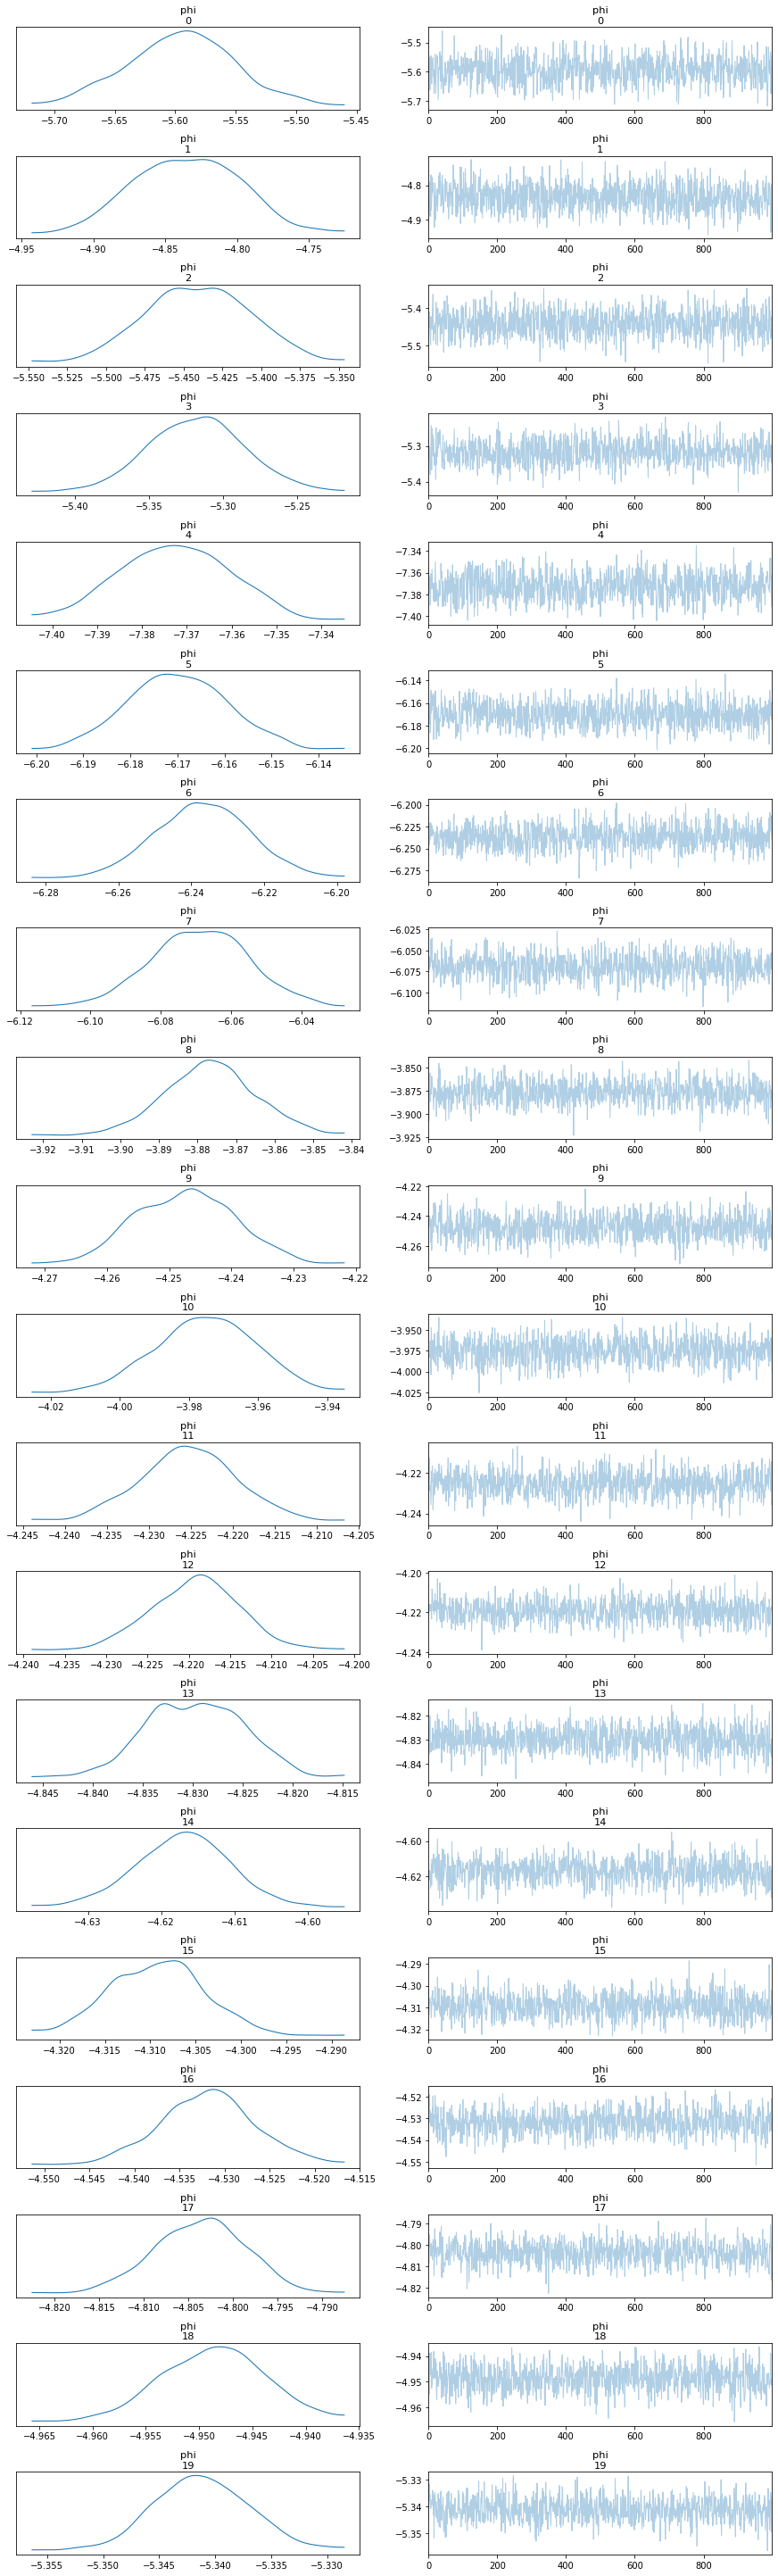

In [62]:
az.plot_trace(svi_az.posterior['phi'], compact=False)
plt.show()

/Users/marcusdaly/Documents/Grad/Y1S1/MLWithProbProg/Probabilistic-Programming/venv/lib/python3.8/site-packages/arviz/plots/plot_utils.py:477: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (46) in plot_posterior, generating only 40 plots
  warnings.warn(


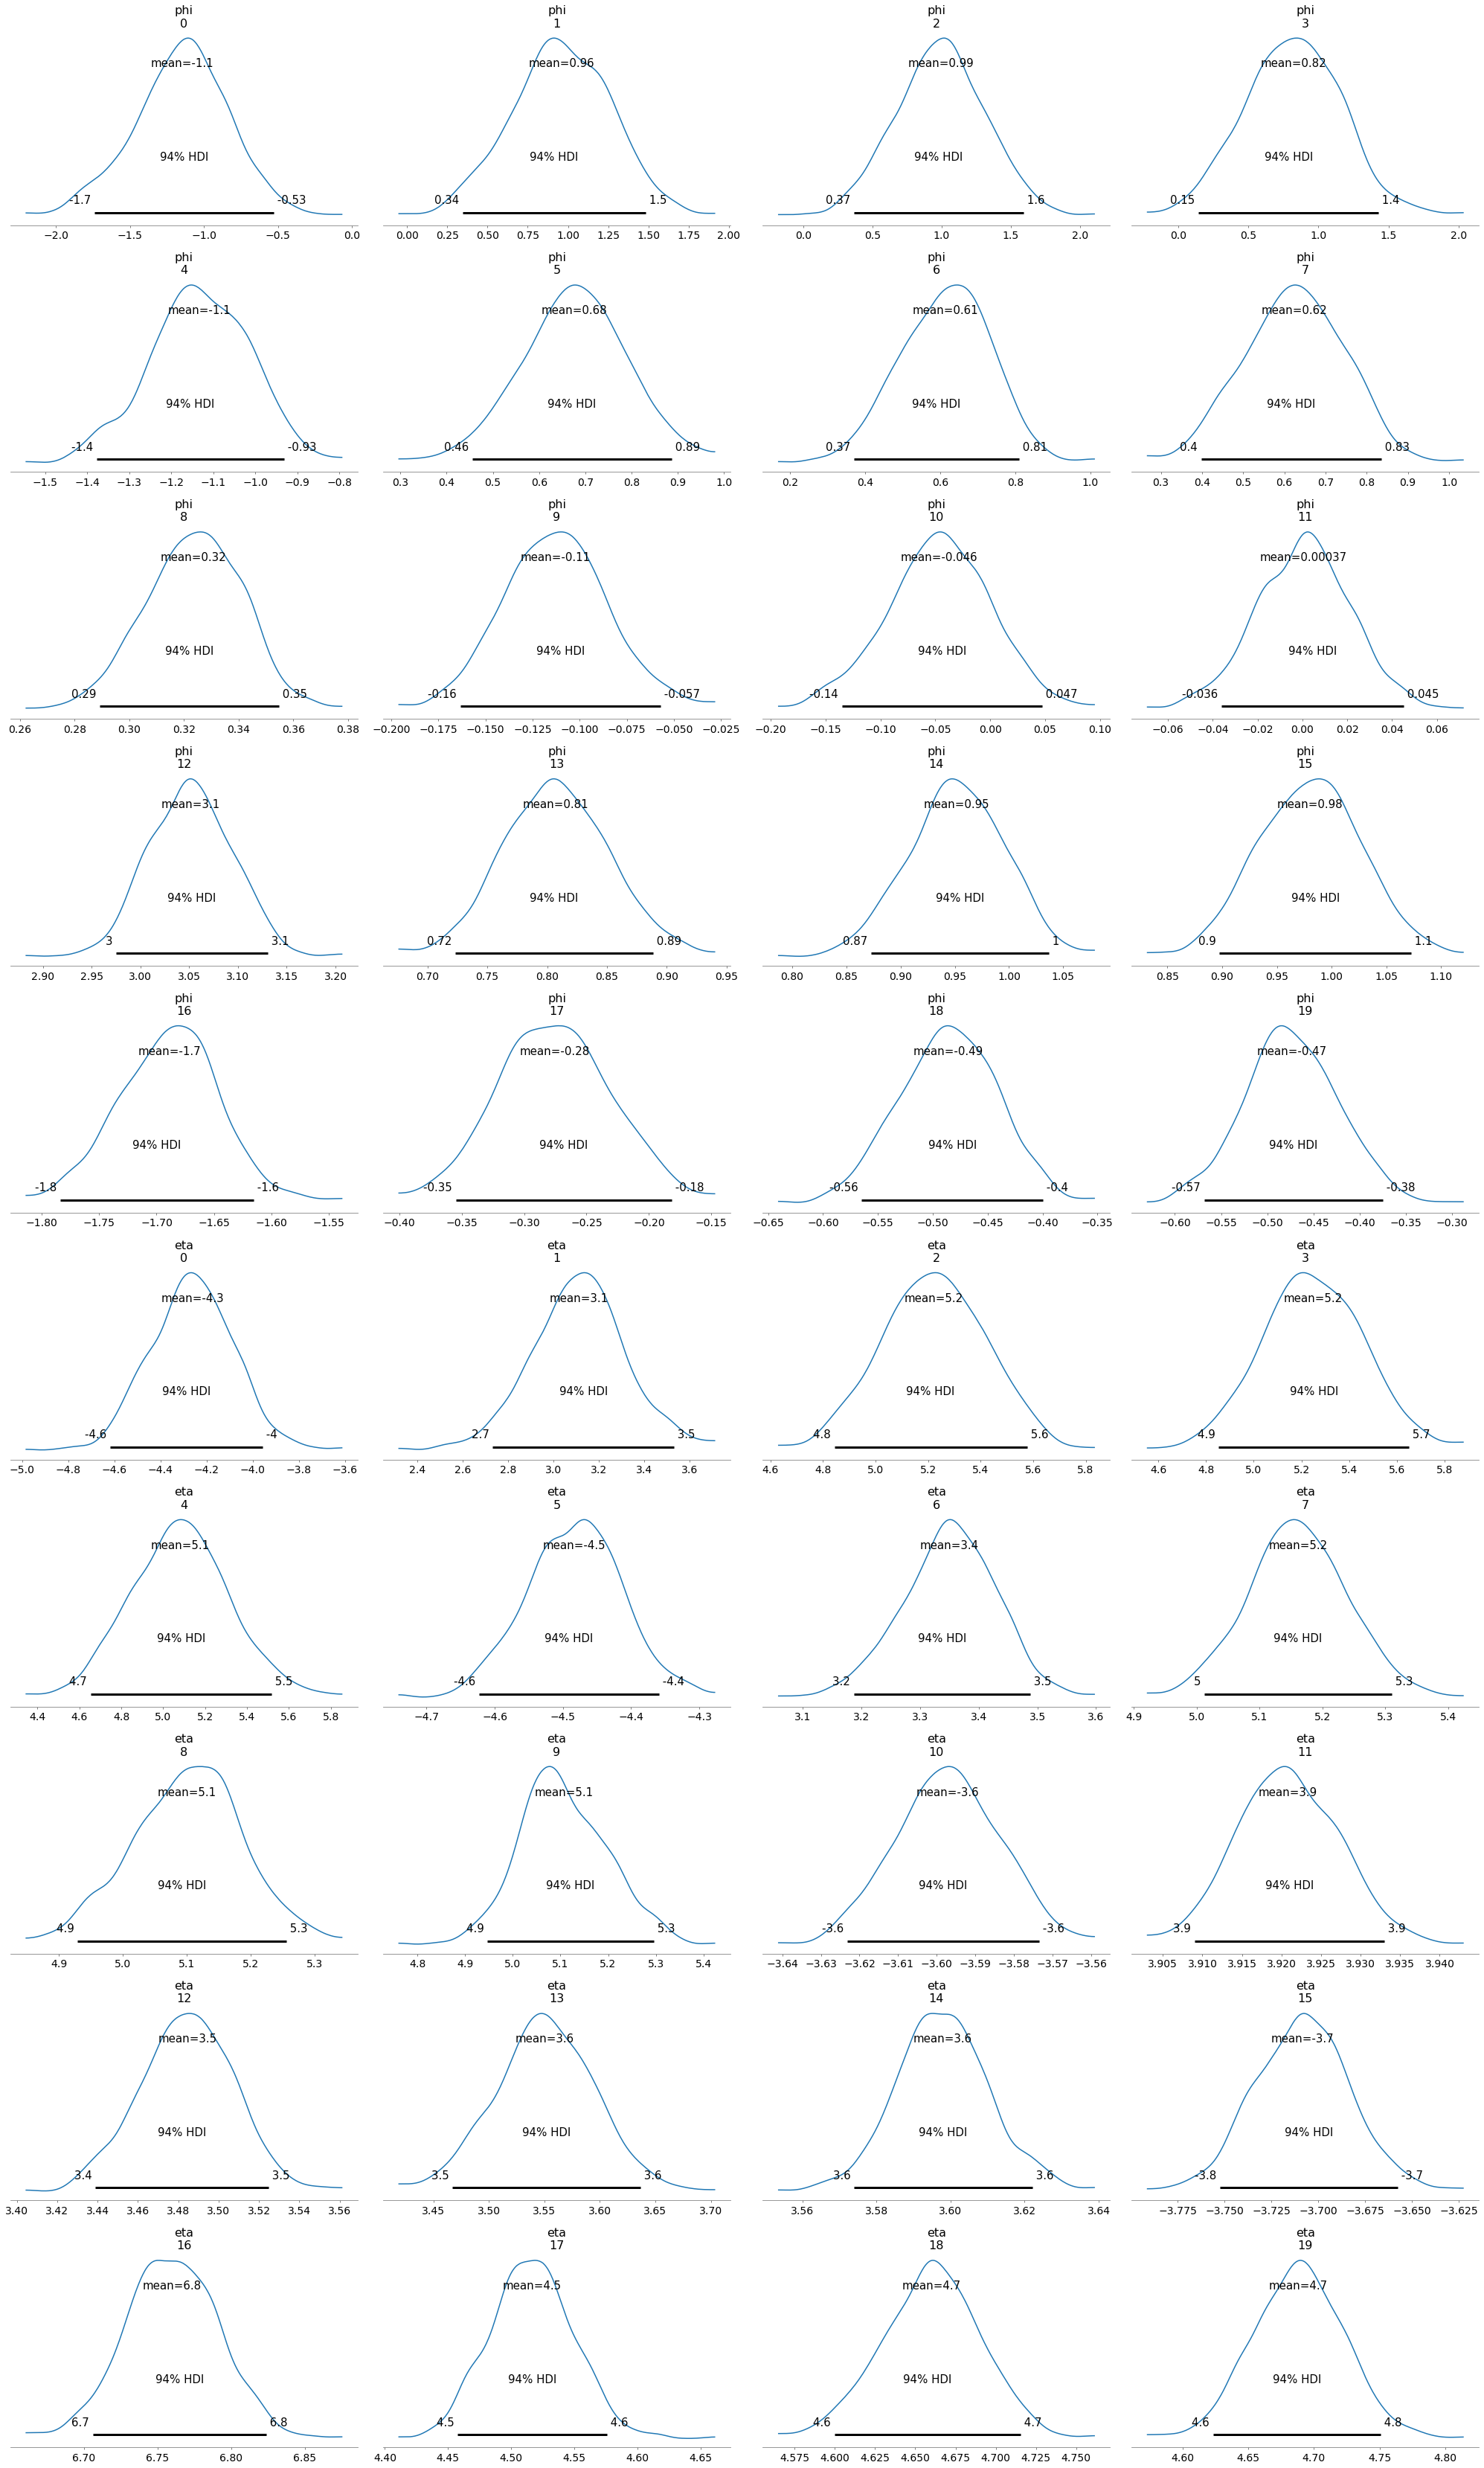

In [120]:

az.plot_posterior(svi_az)
plt.show()

---

Posterior predictive checks

In [85]:
y_train = np.array(y_train)
uniq = np.unique(y_train).astype(int)
cum_density = []

for i in uniq:
    density = (y_train <= i).mean()
    cum_density.append((i, density))
    
cum_density = np.array(cum_density)

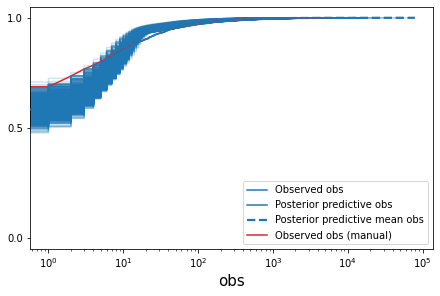

In [86]:
az.plot_ppc(svi_az, kind='cumulative')
plt.xscale('log')
plt.plot(cum_density[:,0], cum_density[:,1], c='tab:red', label='Observed obs (manual)')
#plt.yscale('log')
#plt.xlim(0, 400)
#plt.ylim(0, 0.05)
plt.set_cmap('jet')
plt.legend(loc="lower right")
plt.show()

- Max value

In [87]:
np.max(y_train)

5616.0

In [88]:
np.max(svi_samples['obs'])

78710.0

In [89]:
np.mean(y_train)

17.010917173301955

In [90]:
np.mean(svi_samples['obs'])

16.28253873308492

In [91]:
np.min(y_train)

0.0

In [92]:
np.min(svi_samples['obs'])

0.0

In [93]:
maxes = np.max(svi_samples['obs'].reshape(1000,-1), axis=1)

In [94]:
np.sum(maxes > np.max(y_train))

927

In [95]:
np.log(np.max(y_train))

8.633374945705647

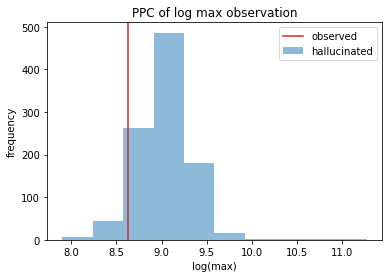

In [96]:
plt.hist(np.log(maxes), alpha=0.5, label="hallucinated")
plt.axvline(np.log(np.max(y_train)), color="tab:red", label="observed")
plt.title("PPC of log max observation")
plt.xlabel("log(max)")
plt.ylabel("frequency")
plt.legend()
plt.show()

- % obs that are 0

In [97]:
(y_train == 0).mean()

0.5831208733738642

In [98]:
(svi_samples['obs'] == 0).mean()

0.5807452441655226

- % obs that are less than 10

In [99]:
(y_train < 10).mean()

0.8486631365627247

In [100]:
(svi_samples['obs'] < 10).mean()

0.8238886709812382

- % obs that are above 1k

In [101]:
(y_train > 1000).mean()

0.0029417532849578347

In [59]:
(svi_samples['obs'] > 1000).mean()

0.0025677794473116873

# Why Pareto?
Our distribution of total comments follows a power law.

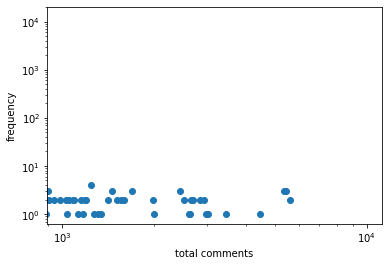

In [46]:
max_ct = np.max(y)
unique, counts = np.unique(y, return_counts=True)
plt.scatter(unique, counts)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("total comments")
plt.ylabel("frequency")
plt.show()

Fake news: expect relatively flatter (more with lots, fewer with few!)

Reviews: expect steeper (fewer comments very common)

Note that our first hour comments are also distributed similarly.

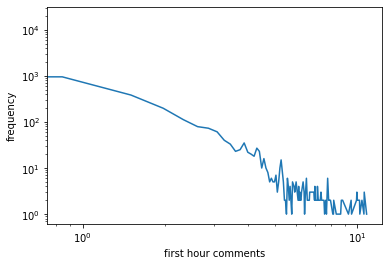

In [48]:
max_ct = np.max(p_data[:,1])
unique, counts = np.unique(p_data[:,1], return_counts=True)
plt.plot(unique, counts)
plt.yscale("log")
plt.xscale("log")
#plt.xlim(1, 10000)
plt.xlabel("first hour comments")
plt.ylabel("frequency")
plt.show()

In [ ]:
p_data[:,1].shape